In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/NewFacemaskDetection"

In [3]:
%cd /content/drive/MyDrive/NewFacemaskDetection/

/content/drive/MyDrive/NewFacemaskDetection


In [ ]:
!unzip ./face-mask-12k-images-dataset.zip

In [4]:
# improt the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import cv2
import os
from glob import glob 
import seaborn as sns
from tabulate import tabulate
import random 
import cv2
import os

import warnings
warnings.filterwarnings('ignore')


In [5]:

#Load train and test set
train_dir = '/content/drive/MyDrive/NewFacemaskDetection/Face Mask Dataset/Train'
test_dir = '/content/drive/MyDrive/NewFacemaskDetection/Face Mask Dataset/Test'
val_dir = '/content/drive/MyDrive/NewFacemaskDetection/Face Mask Dataset/Validation'


# Map the images from train folder with train labels to form a DataFrame
def get_all_images_from_subdirectory_to_dataframe(path):
  configfiles = [os.path.join(dirpath, f)
      for dirpath, dirnames, files in os.walk(path)
      for f in files if f.endswith('.png')]
  images_list = [(i.split("/")[-2],i.split("/")[-1], i) for i in configfiles]
  return images_list


df_list = get_all_images_from_subdirectory_to_dataframe(train_dir)
df_train = pd.DataFrame(data=df_list, columns=['class', 'image_name', 'image_path'])

df_list = get_all_images_from_subdirectory_to_dataframe(test_dir)
df_test = pd.DataFrame(data=df_list, columns=['class', 'image_name', 'image_path'])

df_list = get_all_images_from_subdirectory_to_dataframe(val_dir)
df_val = pd.DataFrame(data=df_list, columns=['class', 'image_name', 'image_path'])

df_val.head(2)

,class,image_name,image_path
0,WithMask,421.png,/content/drive/MyDrive/NewFacemaskDetection/Fa...
1,WithMask,2.png,/content/drive/MyDrive/NewFacemaskDetection/Fa...


Validation Images


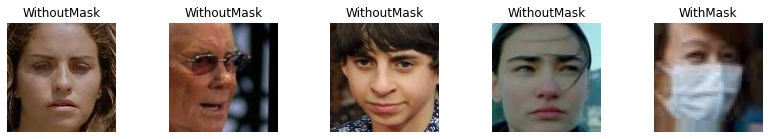

In [6]:
# Write a function that will select n random images and display images along with its species
def plot_random_images(df, total_image=2):
    import matplotlib.image as mpimg
    fig, axes = plt.subplots(1, total_image,figsize=(14,2))
    images_data = list(zip(df['image_path'],df['class']))
    samples = random.sample(images_data,total_image)
    for ax, (image, label) in zip(axes, samples):
        image = mpimg.imread(image)
        ax.set_axis_off()
        ax.imshow(image, cmap = 'binary')
        ax.set_title(f'{label}')


print("Validation Images")
plot_random_images(df_val, 5)

training distribution

		class Distribution

+----+-------------+-------------------+
|    | Category    |   classPercentage |
|----+-------------+-------------------|
|  0 | WithMask    |                50 |
|  1 | WithoutMask |                50 |
+----+-------------+-------------------+


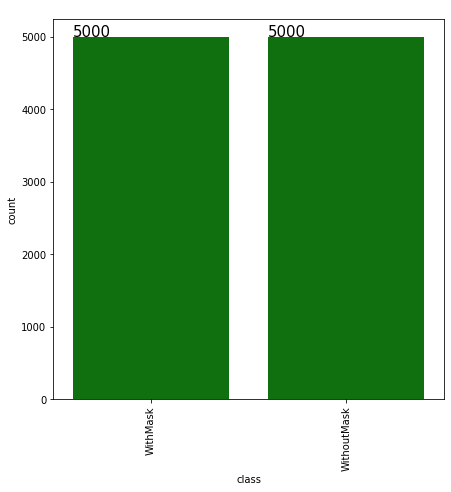

In [7]:
def categroy_distribution(data, col, top=None):
    print("\t\t{} Distribution".format(col))
    print()
    perc = round(data[col].value_counts(normalize=True)[:top]*100,2)

    dataCat = perc.to_frame().reset_index().rename(columns={'index':'Category',
                                                          col:f'{col}Percentage'})
    print(tabulate(dataCat, headers = 'keys', tablefmt = 'psql'))
    plt.figure(figsize=(7,7))
    fig = sns.countplot(x=col, data=data, color="g", order=data[col].value_counts().iloc[:top].index)
    for p in fig.patches:
        fig.annotate(f'\n{p.get_height()}', (p.get_x(), p.get_height()+10), size=15)
    plt.xticks(rotation=90)
    plt.show()


print("training distribution\n")
categroy_distribution(df_train,'class')

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import os

from IPython.display import clear_output
import time
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix
import seaborn as sns
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16

from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from tensorflow.keras.layers import Input
from keras.preprocessing.image import ImageDataGenerator




# Data augmentation
# ImageDataGenerator
train_datagen = ImageDataGenerator( horizontal_flip=True, rotation_range=10,
                                   height_shift_range=0.2,shear_range=0.2,
                                   width_shift_range=0.2,brightness_range=[0.2,1.2],
                                  rescale= 1./255,
                                  zoom_range=0.2,)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224,224),
        batch_size=32,
        shuffle = False,
        seed = 42,
         class_mode = "categorical",
        classes = ['WithoutMask','WithMask'])

test_set = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224,224),
        seed = 42,
        shuffle = False,
        batch_size=32,
        class_mode = "categorical",
        classes = ['WithoutMask','WithMask'])

val_set = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224,224),
        seed = 42,
        shuffle = False,
        batch_size=32,
        class_mode = "categorical",
        classes = ['WithoutMask','WithMask'])

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [9]:
# function for evaluation metrics precision, recall, f1 etc
def modelEvaluation(predictions, y_test_set):
    # Print model evaluation to predicted result    
    start_time = time.time()
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))
    print ("\nClassification report : \n", classification_report(y_test_set, predictions))
    print ("\nConfusion Matrix : \n", confusion_matrix(y_test_set, predictions))
    cm = confusion_matrix(y_test_set, predictions)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    end = round(time.time()-start_time,3)
    results = [accuracy_score(y_test_set, predictions),precision_score(y_test_set, predictions),
              recall_score(y_test_set, predictions),f1_score(y_test_set, predictions)]
    return results

In [10]:
def plot_acc_loss(result, epochs):
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_accuracy')
    plt.plot(range(1,epochs), val_acc[1:], label='Val_accuracy')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Val_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()



In [16]:
def build_pretrained_model(model_object,nb_epochs=10):

  baseModel = model_object(weights="imagenet", include_top=False, input_shape = [224,224,3],input_tensor=Input(shape=(224, 224, 3)))
  
  for layer in baseModel.layers:
    layer.trainable = False

  model = Sequential()
  model.add(baseModel)
  model.add(AveragePooling2D(pool_size=(7,7)))
  model.add(Flatten())
  model.add(Dense(128,activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(2,activation="softmax"))

  INIT_LR = 1e-4
  BS = 32

  print("[INFO] compiling model...")
  opt = Adam(lr=INIT_LR, decay=INIT_LR / nb_epochs)
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


  print("[INFO] training head...")
  history = model.fit_generator(train_set,
                                steps_per_epoch=300,
                                epochs=nb_epochs,validation_data=val_set)
  # plotting the graph
  plot_acc_loss(history, nb_epochs)
  #print (history)

  test_pred = model.predict(test_set)
  test_pred = np.argmax(test_pred,axis = 1)
  test_labels = test_set.labels
  return test_labels,test_pred, model

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
300/300 [==============================] - 179s 587ms/step - loss: 0.3600 - accuracy: 0.8413 - val_loss: 0.0771 - val_accuracy: 0.9712
Epoch 2/20
300/300 [==============================] - 165s 550ms/step - loss: 0.1370 - accuracy: 0.9486 - val_loss: 0.0617 - val_accuracy: 0.9825
Epoch 3/20
300/300 [==============================] - 163s 544ms/step - loss: 0.1056 - accuracy: 0.9621 - val_loss: 0.0362 - val_accuracy: 0.9912
Epoch 4/20
300/300 [==============================] - 164s 546ms/step - loss: 0.0916 - accuracy: 0.9663 - val_loss: 0.0305 - val_accuracy: 0.9912
Epoch 5/20
300/300 [==============================] - 165s 548ms/step - loss: 0.0830 - accuracy: 0.9689 - val_loss: 0.0269 - val_accuracy: 0.9925
Epoch 6/20
300/300 [==============================] - 163s 542ms/step - loss: 0.0688 - accuracy: 0.9744 - val_loss: 0.0253 - val_accuracy: 0.9937
Epoch 7/20
300/300 [==============================] - 160s 534ms/step - lo

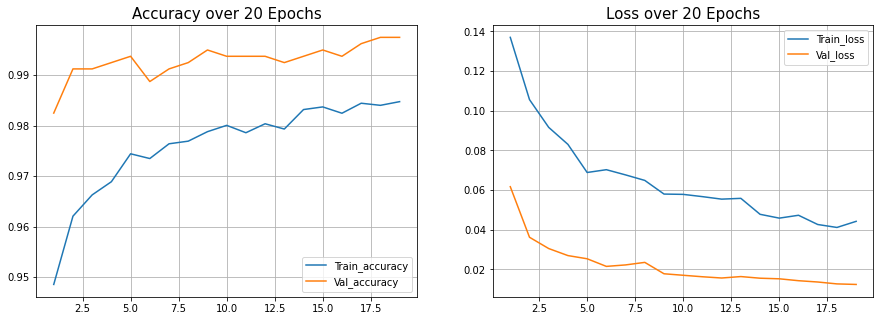

31/31 [==============================] - 6s 167ms/step

Accuracy on validation set: 0.9929

Classification report : 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       504
           1       1.00      0.99      0.99       488

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992


Confusion Matrix : 
 [[503   1]
 [  6 482]]


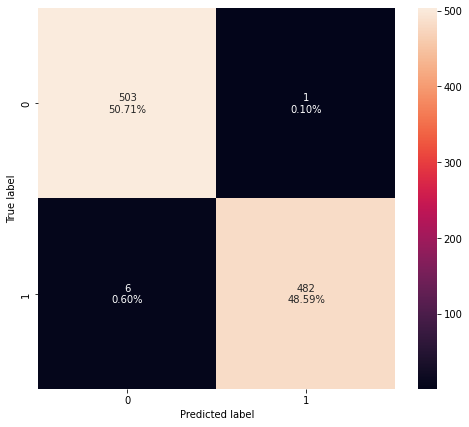

In [17]:

#only run this when we need to retrain network
y_test_mobilenet,y_pred_mobilenet, modelMobileNet = build_pretrained_model(MobileNetV2,nb_epochs=20)
results_mobilenet = modelEvaluation(y_test_mobilenet,y_pred_mobilenet)

In [2]:
# showing all models result
dic = {
    'Metrics':['accuracy','precision','recall','f1-score'],
    'MobileNet' : results_mobilenet

}
metrics_df = pd.DataFrame(dic)

metrics_df = metrics_df.set_index('Metrics')
# displaying the DataFrame
print(tabulate(metrics_df.T, headers = 'keys', tablefmt = 'psql'))

NameError: ignored

In [ ]:
# serialize model to JSON
from keras.models import model_from_json
model_json = modelMobileNet.to_json()
with open("/content/drive/MyDrive/NewFacemaskDetection/FaceMaskDetection_model_file_MobileNet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
modelMobileNet.save_weights("/content/drive/MyDrive/NewFacemaskDetection/FaceMaskDetection_model_file_MobileNet.h5")
print("Saved model to disk")
 

Saved model to disk


In [ ]:
# load json and create model
from keras.models import model_from_json
json_file = open("/content/drive/MyDrive/FaceMaskDetectionDataset/FaceMaskDetection_model_file_MobileNet.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/FaceMaskDetectionDataset/FaceMaskDetection_model_file_MobileNet.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
import dlib
import imutils
dlib_detector = dlib_detector = dlib.get_frontal_face_detector()
#dlib_detector = dlib.cnn_face_detection_model_v1('/content/drive/MyDrive/NewFacemaskDetection/mmod_human_face_detector.dat')
mask_label = {0:'NO MASK',1:'MASK'}


# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    coordinate_list = dlib_detector(gray)
    for i, face in enumerate(coordinate_list):
      try:
          x1,y1,x2,y2 = face.left(), face.top(),face.right(),face.bottom()
          #x1,y1,x2,y2 = face.rect.left(), face.rect.top(),face.rect.right(),face.rect.bottom()
          #print("face:",i," >> ",x1,y1,x2,y2)

          ROI = img[y1:y1+224, x1:x1+224]
          if (x2-x1<y2-y1):
              ROI = img[y1:y2, x1:x1+y2-y1]
              ROI = imutils.resize(ROI, width = 224 )
          elif (y2-y1 <224):
              ROI = img[y1:y1+x2-x1, x1:x2]
              ROI = imutils.resize(ROI, height=224 )

          ROI = np.reshape(ROI, (1, 224, 224,3))
          face_mask = np.reshape(ROI,[1,224,224,3])
          face_mask = face_mask/255.0
          label = np.argmax(loaded_model.predict(face_mask, verbose=0))
          title= mask_label[label]
          
          #testing
          #title ="test"

          bbox_array = cv2.rectangle(bbox_array,(x1,y1), (x2, y2), (0,255,0), 2)
          cv2.putText(bbox_array,title, (x1,y1), cv2.FONT_HERSHEY_COMPLEX,1,(244,250,250),2)
      except:
          print('pass')
     

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes   
        
  
